In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [19]:
df = pd.read_csv('repcount.csv')

In [20]:
#TODO: Implement volume for muscle groups. volume_chest, volume_back, etc.
#TODO: 

### 🔴 1. Calculate Descriptive Statistics

In [21]:
'''
DESCRIPTIVE STATS DESCRIPTIVE STATS DESCRIPTIVE STATS DESCRIPTIVE STATS DESCRIPTIVE STATS DESCRIPTIVE STATS DESCRIPTIVE STATS DESCRIPTIVE STATS 
DESCRIPTIVE STATS DESCRIPTIVE STATS DESCRIPTIVE STATS DESCRIPTIVE STATS DESCRIPTIVE STATS DESCRIPTIVE STATS DESCRIPTIVE STATS DESCRIPTIVE STATS 
'''

# Number of Workouts 
no_of_workouts = df['Workout Start'].unique().shape[0]

# Setup
workout_duration = df.copy()
workout_duration = workout_duration.groupby(['Workout Start', 'Workout End']).sum()
workout_duration.reset_index(inplace=True)
workout_duration['Workout Start'] = pd.to_datetime(workout_duration['Workout Start'], errors='coerce')
workout_duration['Workout End'] = pd.to_datetime(workout_duration['Workout End'], errors='coerce')
workout_duration['Duration'] = (workout_duration['Workout End'] - workout_duration['Workout Start']).dt.total_seconds() / 60

# Total Monthly Workout Duration
monthly_workout_duration = workout_duration.groupby(workout_duration['Workout Start'].dt.month).sum()
monthly_workout_duration = monthly_workout_duration.reset_index()
monthly_workout_duration['Duration'] /= 60
monthly_workout_duration['Workout Start'] = monthly_workout_duration['Workout Start'].map(
    { 1 : "January",
       2 : "February",
       3 : "March",
       4 : "April",
       5 : "May",
       6 : "June",
       7 : "July",
       8 : "August",
       9 : "September",
       10 : "October",
       11 : "November",
       12 : "December"})

# Average Workout Duration
average_workout_duration = workout_duration['Duration'].mean()



### 🔴 2. Calculate Volume Per Muscle Group Per Workout

In [22]:
exercise_details = 'Incline Dumbbell Press (30°)'
df[df.Exercise == exercise_details].drop(['Workout End', 'Notes', 'Kcal', 'Distance', 'Duration', 'Category', 'Name'], axis=1)

,Workout Start,Exercise,Weight,Reps
0,2022-07-06 20:27,Incline Dumbbell Press (30°),14.0,15.0
1,2022-07-06 20:27,Incline Dumbbell Press (30°),16.0,13.0
2,2022-07-06 20:27,Incline Dumbbell Press (30°),16.0,11.0
65,2022-06-30 20:11,Incline Dumbbell Press (30°),14.0,15.0
66,2022-06-30 20:11,Incline Dumbbell Press (30°),16.0,12.0
67,2022-06-30 20:11,Incline Dumbbell Press (30°),16.0,11.0
139,2022-06-27 20:32,Incline Dumbbell Press (30°),14.0,10.0
140,2022-06-27 20:32,Incline Dumbbell Press (30°),12.0,14.0
141,2022-06-27 20:32,Incline Dumbbell Press (30°),12.0,11.0
161,2022-06-22 20:21,Incline Dumbbell Press (30°),12.0,13.0


In [23]:
'''
VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME 
VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME VOLUME 
'''

# Keep only day on date 
df['Workout Start'] = pd.to_datetime(df['Workout Start'])
#.dt.strftime('%Y-%m-%d')
df['Workout End'] = pd.to_datetime(df['Workout Start'])
#.dt.strftime('%Y-%m-%d')

# Derive volume (reps * weight) for each exercise 
df['Volume'] = df['Weight'] * df['Reps']
df_volume = df.groupby(['Workout Start', 'Category', 'Exercise']).sum()


df_volume = df_volume.drop(['Weight', 'Reps', 'Kcal', 'Distance', 'Duration'], axis=1)
df_cardio = pd.DataFrame(df[df.Exercise == 'Running'].groupby(['Workout Start', 'Exercise']).sum())
df_cardio = df_cardio.drop(['Weight', 'Reps', 'Kcal'], axis=1)
# Reset Index
df_volume.reset_index(inplace=True)
df_cardio.reset_index(inplace=True)



# Rename columns
df_volume = df_volume.rename(columns={'Workout Start': 'Date'})
df_cardio = df_cardio.rename(columns={'Workout Start': 'Date'})

# Remove 0 values in volume where the exercise was probably not done but was not removed either
df_volume = df_volume[df_volume.Volume != 0]
df_cardio = df_cardio[df_cardio.Distance !=0]

# Manually double single-arm / single-leg volume
ex = ['High Cable Row', 'Decline Dumbbell Curls', 'Incline Dumbbell Curls', 'Rear Delt Flys', 'High Cable Flies',  'Incline Dumbbell Press (30°)',  'Lateral Cable Raises',  'Shoulder Dumbbell Press',  'Standing Calf Raises (bodyweight)']

# conditions = [df_volume['Exercise'] not in ex,
#               df_volume['Exercise'] in ex]
# choices = [df_volume['Volume'], 
#            df_volume['Volume'] * 2]

# df_volume['Volume'] = np.select(conditions, choices, default=0)
for i in range(df_volume.shape[0]):
    if df_volume.iloc[i].Exercise in ex:
        df_volume.iloc[i, 3] = df_volume.iloc[i, 3] * 2


# TODO: Reconsider this. RDLs may be in both push and pulls so it might be unwise to group by name. Maybe group by exercise only and extract exercises some other 
# Separate PUSH PULL LEGS
df_volume_chest = df_volume[(df_volume.Category == 'Chest')]
df_volume_shoulders = df_volume[(df_volume.Category == 'Shoulders')]
df_volume_triceps = df_volume[(df_volume.Category == 'Triceps')]
df_volume_back = df_volume[(df_volume.Category == 'Back')]
df_volume_biceps = df_volume[(df_volume.Category == 'Biceps')]
df_volume_legs = df_volume[(df_volume.Category == 'Legs')]
df_volume_abs = df_volume[(df_volume.Category == 'Abs')]

# 
df_workout_volume = pd.DataFrame(df_volume.groupby(['Category', 'Date']).sum())
df_workout_volume.reset_index(inplace=True)

### 🔴 3. Plot Statistics and Volume

In [24]:
figsize=(12,4)
legendsize=10

def plot_volume():
    # Plot by muscle group
    muscle_groups = zip([df_volume_chest,
                  df_volume_shoulders,
                  df_volume_triceps,
                  df_volume_back,
                  df_volume_biceps,
                  df_volume_legs,
                  df_volume_abs],
                ['Chest', 
                 'Shoulders', 
                 'Triceps',
                'Back',
                'Biceps',
                'Legs',
                'Abs'])


    for data, name in muscle_groups:
        sns.set_theme(style="darkgrid")
        plt.figure(figsize=figsize)
        sns.lineplot(x='Date', y='Volume', data=data, ci=None, hue='Exercise')
        sns.scatterplot(x='Date', y='Volume', data=data, ci=None, marker='o', s=70, hue='Exercise')
        plt.xlabel('Date', fontsize=15)
        plt.ylabel('Volume', fontsize=15)
        plt.title(f'{name} Workout Volume Progression', fontsize=20)
        plt.legend(loc='upper left', prop={'size': legendsize})
        plt.show()
        
def plot_cardio(data):
    # Plot Cardio
    sns.set_theme(style="darkgrid")
    plt.figure(figsize=figsize)
    sns.barplot(x='Date', y='Distance', data=data, ci=None, hue='Exercise')
    #sns.scatterplot(x='Date', y='Distance', data=data, ci=None, marker='o', s=70, hue='Exercise')
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Distance', fontsize=15)
    plt.title(f'Cardio (Distance)', fontsize=20)
    plt.show()

    sns.set_theme(style="darkgrid")
    plt.figure(figsize=figsize)
    sns.barplot(x='Date', y='Duration', data=data, ci=None, hue='Exercise')
    #sns.scatterplot(x='Date', y='Duration', data=data, ci=None, marker='o', s=70, hue='Exercise')
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Duration', fontsize=15)
    plt.title('Cardio (Duration)', fontsize=20)
    plt.show()

In [25]:
df_volume_chest.sort_values('Date')

,Date,Category,Exercise,Volume
11,2022-06-08 20:46:00,Chest,Flat Chest Press (Technogym),1220.0
12,2022-06-08 20:46:00,Chest,High Cable Flies,657.5
13,2022-06-08 20:46:00,Chest,Incline Dumbbell Press (30°),944.0
37,2022-06-17 19:30:00,Chest,Flat Chest Press (Technogym),1792.5
38,2022-06-17 19:30:00,Chest,High Cable Flies,615.0
39,2022-06-17 19:30:00,Chest,Incline Dumbbell Press (30°),792.0
64,2022-06-22 20:21:00,Chest,High Cable Flies,735.0
65,2022-06-22 20:21:00,Chest,Incline Dumbbell Press (30°),888.0
63,2022-06-22 20:21:00,Chest,Flat Chest Press (Technogym),1665.0
71,2022-06-27 20:32:00,Chest,Flat Chest Press (Technogym),1625.0


+----------------------------------+---------+
|              Stats               |  Value  |
+==================================+=========+
| Total Workouts (since June 2022) | 15      |
+----------------------------------+---------+
| Average Workout Time (mins)      | 97 mins |
+----------------------------------+---------+
| 0                                | 0       |
+----------------------------------+---------+
| 0                                | 0       |
+----------------------------------+---------+


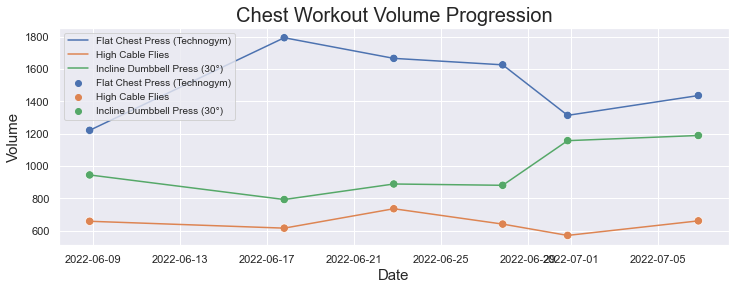

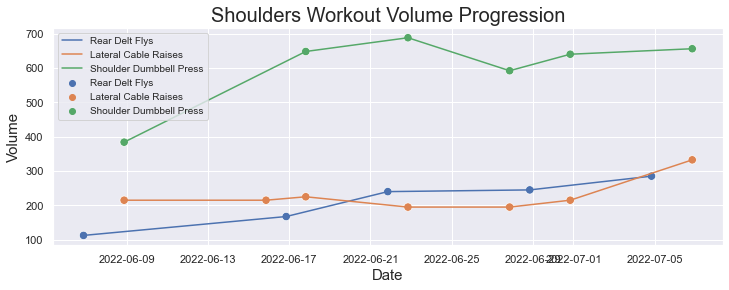

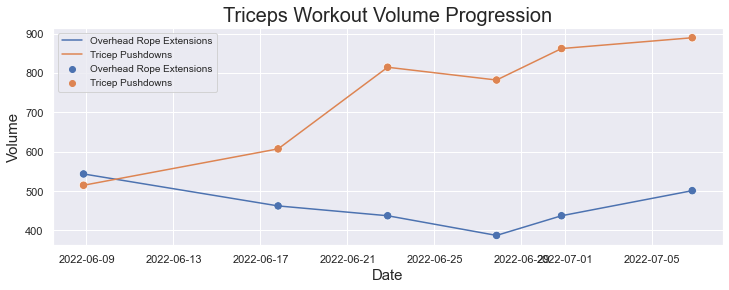

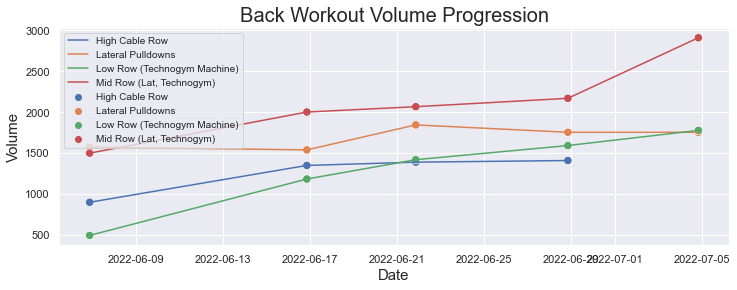

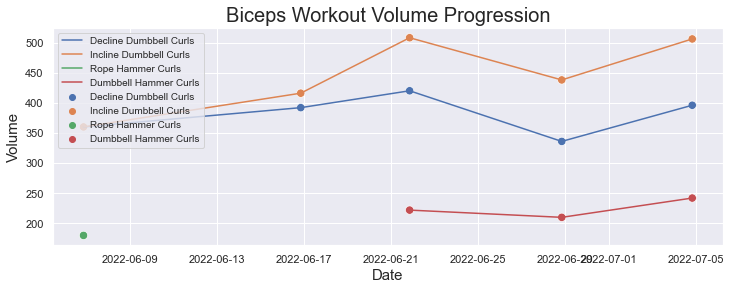

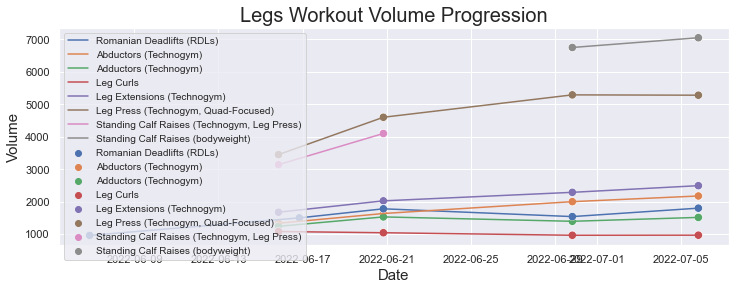

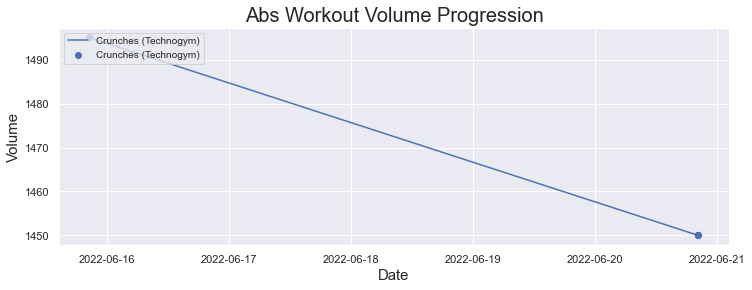

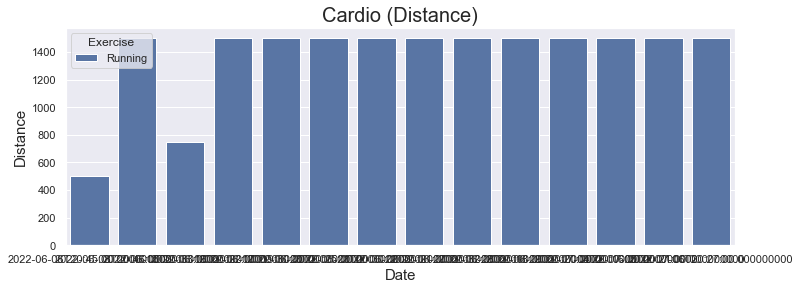

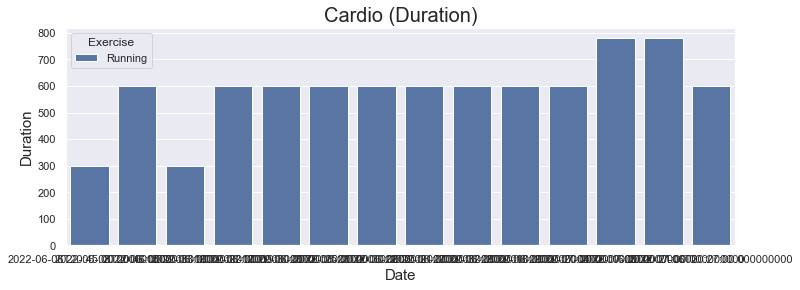

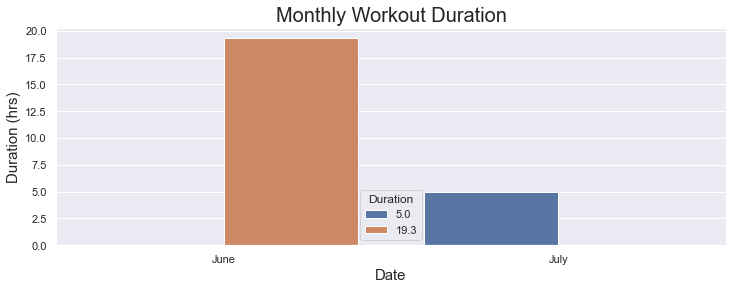

In [26]:
'''STATISTICS TABLE'''
from texttable import Texttable
t = Texttable()
t.add_rows([['Stats', 'Value'], 
            ['Total Workouts (since June 2022)', no_of_workouts], 
            ['Average Workout Time (mins)', str(int(average_workout_duration)) + ' mins'],
            ['0', 0],
            ['0', 0],
           ])
print(t.draw())


'''VOLUME PLOT'''
plot_volume()

'''CARDIO PLOT'''
plot_cardio(df_cardio)

# Monthly Workout Duration
sns.set_theme(style="darkgrid")
plt.figure(figsize=figsize)
sns.barplot(x='Workout Start', y='Duration', data=monthly_workout_duration, ci=None)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Duration (hrs)', fontsize=15)
plt.title('Total Monthly Workout Duration', fontsize=20)
plt.show()

# TODO: Average Monthly Workout Duration (97mins, 95mins, 103mins, ...)